In [2]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
pd.options.display.max_columns = 200

## Make sample sheet

In [6]:
with open("./samples.tsv", "w") as fp:
    fp.write("sample_id\tcondition\treplicate\tfast5_dir\n")

    for i, fast5_dir in enumerate(sorted(glob.glob("./data/yeast/fast5/*"))):
        name = os.path.basename(fast5_dir)
        condition = name.split("_")[0]
        replicate = int(name.split("_")[1][-1])
        fast5_dir = os.path.abspath(fast5_dir)
        fp.write(f"s{i}\t{condition}\t{replicate}\t{fast5_dir}\n")

cat("./samples.tsv")

sample_id	condition	replicate	fast5_dir
s0	KO	0	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/KO_rep0
s1	KO	1	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/KO_rep1
s2	KO	2	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/KO_rep2
s3	WT	0	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/WT_rep0
s4	WT	1	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/WT_rep1
s5	WT	2	/home/aleg/Programming/Packages/MetaCompore/MetaCompore/data/yeast/fast5/WT_rep2


In [21]:
for name in [
    #"input",
    "basecalling",
    "alignment",
    "quality_control",
    "quantification",
    "resquiggling",
    "nanocompore",
    "eligos2",
    "xpore",
    "tombo",
    "mines",
    "epinano",
    "differr_nanopore_DRS"]:
    
    fn = f"workflow/rules/{name}.smk"
    with open (fn, "w") as fp: 

        fp.write("""# -*- coding: utf-8 -*-

##### Imports #####

# Std lib
from os.path import join

##### Rules #####
module_name = "input"

rule_name="rule1"
rule rule1:
    input: fa=transcriptome_fa
    output: fa=join("results", module_name, rule_name, "transcriptome_reference.fa")
    log: join("logs",module_name, rule_name, "name.log")
    threads: get_threads(config, rule_name)
    params: opt=get_opt(config, rule_name)
    resources: mem_mb=get_mem(config, rule_name)
    container: "library://aleg/default/CONTAINER:TAG"
    script: "scripts/SCRIPT.py" """)



In [34]:
for name in [
    "guppy",
#     "minimap2",
#     "qc",
#     "quantification",
#     "nanopolish",
#     "nanocompore",
#     "eligos2",
#     "xpore",
#     "tombo",
#     "mines",
    #"get_transcriptome"
    ]:
    
    fn = f"workflow/scripts/{name}.py"
    with open (fn, "w") as fp: 

        fp.write("""# -*- coding: utf-8 -*-

##### Imports #####

from foo import bar


##### DEFINE SCRIPT FUNCTION #####

def function():
    pass


##### RUN SCRIPT FUNCTION #####

function():
""")

## Test functions 

In [19]:
##### Imports #####

from collections import OrderedDict
import logging
from pyBioTools import Fasta
from pyfaidx import Faidx


##### DEFINE SCRIPT FUNCTION #####

def get_transcriptome(fa_input, fa_output, fai_output, log_fn):
    with open (log_fn, "w") as log_fp:
        logging.basicConfig(filename=log_fp, level=logging.DEBUG)

        try:
            # Parse fasta file uncompress and simplify transcript ids
            logging.info("Read input transcriptome fasta file")
            with open(fa_output, "w") as fa_out:
                for rec in Fasta.Reader(fa_input):
                    fa_out.write(">{}\n{}\n".format(rec.short_name, rec.seq))

            logging.info("Index fasta file")
            with Faidx(fa_output) as fa_out:
                fa_out.build_index()

        except:
            logging.exception('Error while running get_transcriptome')
            raise

In [18]:
get_transcriptome(
    fa_input="./data/reference/transcriptome_reference.fa",
    fa_output="./results/transcriptome_reference.fa",
    fai_output="./results/transcriptome_reference.fa.fai",
    log_fn="./logs/transcriptome_reference.log")

## Downsample from fast5 source and create

In [25]:
from ont_fast5_api.fast5_interface import get_fast5_file
from ont_fast5_api.conversion_tools.fast5_subset import Fast5Filter
from random import shuffle
random.seed(42)

def get_read_id (fast5_filepath):
    l = []
    with get_fast5_file(fast5_filepath, mode="r") as f5:
        for read in f5.get_reads():
            l.append(read.read_id)            
    return l


In [31]:
n = 500
replicates = list(range())

for fast5_in in ["./data/fast5/control/FAL77200_pass_349ad0ae_0.fast5", "./data/fast5/modified/FAL82837_pass_9638a095_0.fast5"]:
    stdout_print(f"Sample source {fast5_in}\n")
    workdir = os.path.dirname(fast5_in)
    l = get_read_id(fast5_in)
    shuffle(l)
    
    s = 0
    for rep in replicates:
        stdout_print(f"\tReplicate {rep}\n")
        read_list_out = os.path.join(workdir, f"rep{rep}_read_list.txt")
        with open (read_list_out, "w") as fp:
            for r in l[s: s+n]:
                fp.write(f"{r}\n")
        s+=n
        
        stdout_print(f"\tSubsampling Reads\n")
        f = Fast5Filter(
            input_folder = workdir,
            output_folder = f"{workdir}_rep{rep}",
            read_list_file= read_list_out, 
            filename_base="batch",
            batch_size=100,
            threads=5)
        f.run_batch()
    

Sample source ./data/fast5/control/FAL77200_pass_349ad0ae_0.fast5
	Replicate 0
	Subsampling 0


DEBUG:h5py._conv:Creating converter from 5 to 3            |  0% ETA:  --:--:--
| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 1
	Subsampling 1


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 2
	Subsampling 2


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 3
	Subsampling 3


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


Sample source ./data/fast5/modified/FAL82837_pass_9638a095_0.fast5
	Replicate 0
	Subsampling 0


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 1
	Subsampling 1


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 2
	Subsampling 2


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


	Replicate 3
	Subsampling 3


| 501 of 501|###############################################|100% Time: 0:00:01
INFO:Fast5Filter:500 reads extracted


## nanocompore post-process

In [3]:
res_fn = "./results/nanocompore/nanocompore_sampcomp/outnanocompore_results.tsv"
head(res_fn)

pos chr genomicPos ref_id strand ref_kmer GMM_logit_pvalue   GMM_logit_pvalue_context_2 KS_dwell_pvalue    KS_dwell_pvalue_context_2 KS_intensity_pvalue KS_intensity_pvalue_context_2 GMM_cov_type GMM_...
1   NA  NA         ADY2   NA     TGTCT    0.9977266740457584 0.999998837881888          0.9999964262792325 0.9999999354182575        0.9331675079270169  0.5541327005621711            full         2   ...
2   NA  NA         ADY2   NA     GTCTG    nan                nan                        0.9999964262792325 0.9999999354182575        0.1716745282604592  0.1375900164581053            full         1   ...
3   NA  NA         ADY2   NA     TCTGA    0.9977266740457584 0.999998837881888          0.9999964262792325 0.9999999354182575        0.9060848443566195  0.3486977913612505            full         2   ...
4   NA  NA         ADY2   NA     CTGAC    0.9977266740457584 0.999998837881888          0.9999964262792325 0.9999999354182575        0.7954059220296367  0.3746523769429156            f

In [4]:
tests_d = {
"GMM_logit_pvalue": {"peak":"GMM_logit_peak" ,"label":"GMM_context_0"},
"GMM_logit_pvalue_context_2": {"peak":"GMM_logit_peak_context_2", "label":"GMM_context_2"},
"KS_intensity_pvalue": {"peak":"KS_intensity_peak", "label":"KS_intensity_context_0"},
"KS_intensity_pvalue_context_2": {"peak":"KS_intensity_peak_context_2", "label":"KS_intensity_context_2"},
"KS_dwell_pvalue": {"peak":"KS_dwell_peak", "label":"KS_dwell_context_0"},
"KS_dwell_pvalue_context_2": {"peak":"KS_dwell_peakontext_2", "label":"KS_dwell_context_2"}}

{'GMM_logit_pvalue': {'peak': 'GMM_logit_peak', 'label': 'GMM_context_0'},
 'GMM_logit_pvalue_context_2': {'peak': 'GMM_logit_peak_context_2',
  'label': 'GMM_context_2'},
 'KS_intensity_pvalue': {'peak': 'KS_intensity_peak',
  'label': 'KS_intensity_context_0'},
 'KS_intensity_pvalue_context_2': {'peak': 'KS_intensity_peak_context_2',
  'label': 'KS_intensity_context_2'},
 'KS_dwell_pvalue': {'peak': 'KS_dwell_peak', 'label': 'KS_dwell_context_0'},
 'KS_dwell_pvalue_context_2': {'peak': 'KS_dwell_peakontext_2',
  'label': 'KS_dwell_context_2'}}

Creating /home/aleg/Programming/Packages/MetaCompore/MetaCompore/tests
timestamp: 2021-02-03 22:10:23.744047
	input_tsv: ./results/nanocompore/nanocompore_sampcomp/outnanocompore_results.tsv
	fasta: ./results/input/get_transcriptome/transcriptome_reference.fa
	outdir: tests
	log: ./tests/log.txt
	p_val_lim: 0.1
	quantile_lim: 0.5
	min_distance: 7
Load Fasta reference lengths

Load and cleanup data

Iterate over transcripts and call peaks

GMM_context_0 counts

	All transcripts:7

	Transcripts without significant pvalues:6

	Transcripts with significant pvalues:1

	Transcripts with peaks called:1

	Significant pvalues:1

	Peaks detected:1

GMM_context_2 counts

	All transcripts:7

	Transcripts without significant pvalues:6

	Transcripts with significant pvalues:1

	Transcripts with peaks called:1

	Significant pvalues:1

	Peaks detected:1

KS_intensity_context_0 counts

	All transcripts:7

	Transcripts without significant pvalues:4

	Transcripts with significant pvalues:3

	Transcripts 

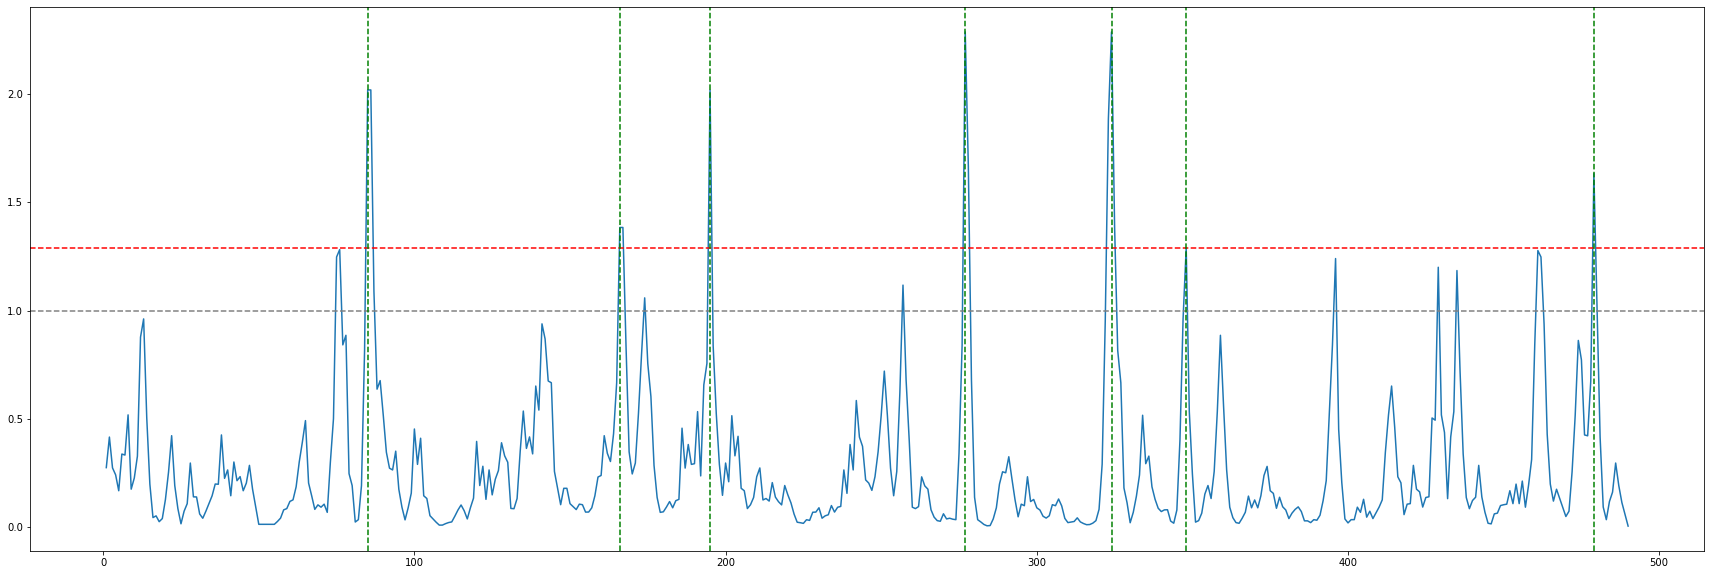

In [91]:
# -*- coding: utf-8 -*-

##### Imports #####
import logging
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import pyfaidx
from scipy.signal import find_peaks
import datetime

##### DEFINE SCRIPT FUNCTION #####
def nanocompore_postprocess (
    input_tsv,
    fasta,
    outdir,
    log,
    p_val_lim=0.01,
    quantile_lim=0.5,
    min_distance=9):

    logging.basicConfig(filename=log, filemode="w", level=logging.INFO, format='%(message)s')
    print("timestamp: {}".format(str(datetime.datetime.now())))
    for i, j in locals().items():
        print("\t{}: {}".format(i,j))

    # Define variables
    sig_lim = -np.log10(p_val_lim)
    min_pval = np.nextafter(float(0), float(1))
    max_pval = 1

    tests_d = {
        "GMM_logit_pvalue": {"peak":"GMM_logit_peak" ,"label":"GMM_context_0"},
        "GMM_logit_pvalue_context_2": {"peak":"GMM_logit_peak_context_2", "label":"GMM_context_2"},
        "KS_intensity_pvalue": {"peak":"KS_intensity_peak", "label":"KS_intensity_context_0"},
        "KS_intensity_pvalue_context_2": {"peak":"KS_intensity_peak_context_2", "label":"KS_intensity_context_2"},
        "KS_dwell_pvalue": {"peak":"KS_dwell_peak", "label":"KS_dwell_context_0"},
        "KS_dwell_pvalue_context_2": {"peak":"KS_dwell_peakontext_2", "label":"KS_dwell_context_2"}}

    # Get transcript lengths in dict for convenience
    print('Load Fasta reference lengths\n')
    with pyfaidx.Fasta(fasta) as fa:
        tx_len_dict = {i.name:len(i) for i in fa}
        
    # Get data and cleanup
    print('Load and cleanup data\n')
    df = pd.read_csv(input_tsv, sep="\t", dtype={'chr':str})

    test_sig_d = OrderedDict()
    print('Iterate over transcripts and call peaks\n')

    for test in list(tests_d.keys()):
        c = Counter()
        test_label = tests_d[test]["label"]

        with open (os.path.join(outdir, f"nanocompore_results_{test_label}.tsv"), "w") as res_fp:
            res_fp.write("ref_id\tpos\tpvalue\tpeak\n")
            # Extract data for current test and cleanup
            test_df = df[["ref_id", "pos", test]].copy()
            test_df = test_df.rename(columns={test:"pvalue"})
            test_df["pvalue"]= test_df["pvalue"].fillna(1)
            test_df["pvalue"] = test_df["pvalue"].clip(min_pval, max_pval)

            # Iterate over tx for peak calling
            for tx, tx_df in test_df.groupby("ref_id"):
                c["All transcripts"]+=1
                x = pd.Series(data=-np.log10(tx_df["pvalue"]).values, index=tx_df["pos"].values)
                x = x.reindex(range(tx_len_dict[tx]))
                x = x.fillna(0)
                sig_val = x[x>=sig_lim]

                if sig_val.empty:
                    c["Transcripts without significant pvalues"]+=1
                else:
                    c["Transcripts with significant pvalues"]+=1
                    threshold = np.quantile(sig_val, quantile_lim)
                    peaks = find_peaks(x, height=threshold, distance=min_distance)[0]
                    if peaks.size == 0:
                        c["Transcripts without peaks called"]+=1
                    else:
                        c["Transcripts with peaks called"]+=1
                        if tx == "RGI2":
                            KEEP= (tx_df, peaks, threshold)

                    # Write significant hits +- peaks
                    for i in tx_df.itertuples():
                        if i.pvalue <=p_val_lim:
                            c["Significant pvalues"]+=1
                            if i.pos in peaks:
                                c["Peaks detected"]+=1
                                peak = True
                            else:
                                peak = False
                            res_fp.write(f"{i.ref_id}\t{i.pos}\t{i.pvalue}\t{peak}\n")

        print(f'{test_label} counts\n')
        for i, j in c.items():
            print(f'\t{i}:{j}\n')
        
    return KEEP
################################################################

rmtree("tests", ignore_errors=True)
mkdir("tests")

##### RUN SCRIPT FUNCTION #####
tx_df, peaks, threshold = nanocompore_postprocess (
    input_tsv="./results/nanocompore/nanocompore_sampcomp/outnanocompore_results.tsv",
    fasta="./results/input/get_transcriptome/transcriptome_reference.fa", 
    outdir="tests",
    log = "./tests/log.txt",
    p_val_lim=0.1,
    quantile_lim=0.5,
    min_distance=7)

fig, ax = pl.subplots(1,1, figsize=(30, 10))
ax.plot(tx_df.pos, -np.log10(tx_df.pvalue))
ax.axhline(-np.log10(0.1), color="gray", ls="--")
ax.axhline(threshold, color="red", ls="--")

for i in peaks:
    ax.axvline(i, color="green", ls="--")

In [90]:
df = pd.read_csv("./tests/nanocompore_results_KS_intensity_context_2.tsv", sep="\t")
df[df.peak == True]

,ref_id,pos,pvalue,peak
4,ADY2,314,0.005185,True
5,ADY2,708,0.052311,True
8,CIT2,397,0.005185,True
10,CIT2,465,0.005185,True
14,CIT2,1211,0.013063,True
16,RDL1,123,0.041372,True
18,RDL1,177,0.041372,True
21,RGI2,85,0.009603,True
24,RGI2,166,0.041372,True
27,RGI2,195,0.009603,True


## Tombo

timestamp: 2021-02-03 22:19:22.152581
	res_h5: ./results/tombo/tombo_level_sample_compare/results.tombo.stats

	fasta: ./results/input/get_transcriptome/transcriptome_reference.fa

	res_tsv: ./tests/tombo_results.tsv

	log: ./tests/log.txt

	min_cov: 30

	p_val_lim: 0.01

	quantile_lim: 0.5

	min_distance: 7

Load Fasta reference lengths

Extract data from hdf5 database

Counts

	All transcripts:8

	Transcripts with significant pvalues:7

	Significant pvalues:62

	Peaks detected:16

	Transcripts without significant pvalues:1

ref_id	pos	pvalue	peak
RDL1	262	0.00671471749976534	True
RDL1	407	0.006503091784466672	True
RDL1	413	0.007343884842739259	False
RGI2	288	0.004484255360062957	False
RGI2	344	0.003758641562830545	False
RGI2	345	0.0026988180589627847	False
RGI2	346	0.0008080786717370106	True
RGI2	347	0.0008543466760379125	False
RGI2	348	0.0014161732962857556	False
RGI2	358	0.0007120685036777218	False
RGI2	359	0.0002364908561145465	False
RGI2	360	0.0009564341724661425	False
RGI2	361	0

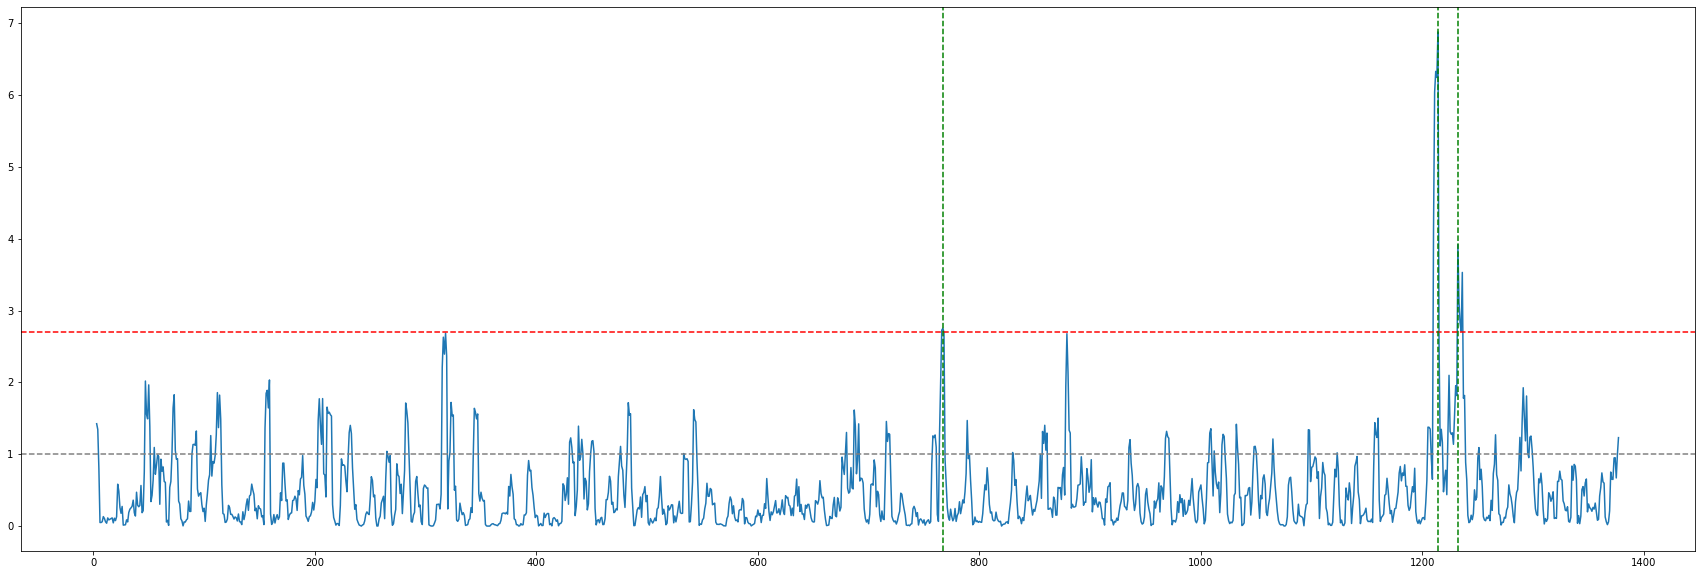

In [99]:
# -*- coding: utf-8 -*-

##### Imports #####

import logging
import numpy as np
import h5py
import pandas as pd
from collections import Counter
import pyfaidx
from scipy.signal import find_peaks
import datetime

##### DEFINE SCRIPT FUNCTION #####
def tombo_postprocess (
    res_h5,
    fasta,
    res_tsv,
    log,
    min_cov=50,
    p_val_lim=0.01,
    quantile_lim=0.5,
    min_distance=9):

    #logging.basicConfig(filename=log, filemode="w", level=logging.INFO, format='%(message)s')
    print("timestamp: {}".format(str(datetime.datetime.now())))
    for i, j in locals().items():
        print("\t{}: {}\n".format(i,j))

    # Define variables
    sig_lim = -np.log10(p_val_lim)
    min_pval = np.nextafter(float(0), float(1))
    max_pval = 1

    # Init collections
    tx_id_set=set()
    c = Counter()
    # first = True

    # Get transcript lengths in dict for convenience
    print(f'Load Fasta reference lengths\n')
    with pyfaidx.Fasta(fasta) as fa:
        tx_len_dict = {i.name:len(i) for i in fa}

    print(f'Extract data from hdf5 database\n')
    with h5py.File(res_h5,'r') as h5, open(res_tsv, "w") as res_fp:
        res_fp.write("ref_id\tpos\tpvalue\tpeak\n")

        for block_id, block_data in h5["Statistic_Blocks"].items():

            # Extract attrs
            tx_id = block_data.attrs['chrm']
            start = block_data.attrs['start']
            strand = block_data.attrs['strand']

            if tx_id in tx_id_set:
                c["Duplicated transcript"]+=1
            elif start > 0:
                c["Transcript with invalid start"]+=1
            elif strand != "+":
                c["Transcript with invalid strand"]+=1
            else:
                tx_df = pd.DataFrame(block_data.get("block_stats")[()])
                tx_df = tx_df.dropna()
                tx_df = tx_df[(tx_df["cov"]>=min_cov) & (tx_df["control_cov"]>=min_cov)]
                if tx_df.empty:
                    c["Low coverage transcripts discarded"]+=1
                    continue

                tx_df.rename(columns={"stat":"pvalue"}, inplace=True)
                tx_df["pvalue"] = tx_df["pvalue"].fillna(1)
                tx_df["pvalue"] = np.clip(tx_df["pvalue"], min_pval, max_pval)

                # Peak calling in -log10 space
                c["All transcripts"]+=1
                x = pd.Series(data=-np.log10(tx_df["pvalue"]).values, index=tx_df["pos"].values)
                x = x.reindex(range(tx_len_dict[tx_id]))
                x = x.fillna(0)
                sig_val = x[x>sig_lim]

                if sig_val.empty:
                    c["Transcripts without significant pvalues"]+=1
                else:
                    c["Transcripts with significant pvalues"]+=1
                    threshold = np.quantile(sig_val, quantile_lim)
                    peaks = find_peaks(x, height=threshold, distance=min_distance)[0]

                    # Write significant hits +- peaks
                    for i in tx_df.itertuples():
                        if i.pvalue <=p_val_lim:
                            c["Significant pvalues"]+=1
                            if i.pos in peaks:
                                c["Peaks detected"]+=1
                                peak = True
                            else:
                                peak = False
                            res_fp.write(f"{tx_id}\t{i.pos}\t{i.pvalue}\t{peak}\n")

                tx_id_set.add(tx_id)

    print(f'Counts\n')
    for i, j in c.items():
        print(f'\t{i}:{j}\n')
    
    return tx_df, peaks, threshold

##### RUN SCRIPT FUNCTION #####
tx_df, peaks, threshold = tombo_postprocess (
    res_h5="./results/tombo/tombo_level_sample_compare/results.tombo.stats",
    fasta="./results/input/get_transcriptome/transcriptome_reference.fa", 
    res_tsv="./tests/tombo_results.tsv",
    log = "./tests/log.txt",
    min_cov=30,
    p_val_lim=0.01,
    quantile_lim=0.5,
    min_distance=7)

fig, ax = pl.subplots(1,1, figsize=(30, 10))
ax.plot(tx_df.pos, -np.log10(tx_df.pvalue))
ax.axhline(-np.log10(0.1), color="gray", ls="--")
ax.axhline(threshold, color="red", ls="--")

for i in peaks:
    ax.axvline(i, color="green", ls="--")

cat("./tests/tombo_results.tsv")

## mines

In [59]:
res_bed = "./results/differr/differr_compare/differr_results.bed"
df = pd.read_csv(res_bed, sep="\t", 
                 names=["refid", "pos", "end", "name", "score", "strand", "odds_ratio", "G_stat","-log10_pval", "-log10_FDR", "G_stat_control", "-log10_pval_control", "G_stat_test", "-log10_pval_test"], 
                 usecols=[0,1,4,6,7,8,9])
df = df.replace(np.inf, np.nan)
df =df.dropna(subset=["score", "-log10_pval"])
df["pvalue"]=np.power(10, -df["-log10_pval"])
df["adj_pvalue"]=np.power(10, -df["-log10_FDR"])
df=df[["refid", "pos", "pvalue", "adj_pvalue", "odds_ratio", "G_stat"]]
df

ValueError: Passed header names mismatches usecols

In [65]:
head("./results/eligos2/eligos2_pair_diff_mod/test_vs_control_on_transcriptome_reference_baseExt0.txt", max_char_line=300)
head("./results/eligos2/eligos2_pair_diff_mod/test_vs_control_on_transcriptome_reference_baseExt1.txt", max_char_line=300)
head("./results/eligos2/eligos2_pair_diff_mod/test_vs_control_on_transcriptome_reference_baseExt2.txt", max_char_line=300)
head("./results/eligos2/eligos2_pair_diff_mod/test_vs_control_on_transcriptome_reference_combine.txt", max_char_line=300)

chrom start_loc end_loc strand name        ref homo_seq kmer5 majorAllel majorAllelFreq     kmer7   test_err_1 ctrl_err_1 test_cor_1 ctrl_cor_1 oddR                pval                   adjPval             baseExt total_reads ESB_test             ESB_ctrl             
ADH2  16        17      +      ADH2:1-1047 C   --       AACTC C          1.0                AACTCAA 20         37         98         81         0.4483051312356334  0.014524390240423986   1.0                 0       118         0.1694915254237288   0.3135593220338983   
ADH2  105       106     +      ADH2:1-1047 A   --       TAATC A          1.0                TAATCAA 1          9          119        118        0.11091558498776474 0.019517591209349885   1.0                 0       120         0.008333333333333333 0.07086614173228346  
ADH2  114       115     +      ADH2:1-1047 A   --       TCAAA A          1.0                TCAAATA 19         35         101        92         0.49588300087724346 0.0310232557929888     1.0

In [85]:
min_oddR = 1
min_esb = 0
min_cov = 30
max_adj_pval = 0.1
discard_homopolymers = True
ref_base = None

res_tsv = "./results/eligos2/eligos2_pair_diff_mod/test_vs_control_on_transcriptome_reference_combine.txt"

df = pd.read_csv(res_tsv, sep='\t')
if oddR is not None:
    df = df[df["oddR"] >= min_oddR]
if esb is not None:
    df = df[df["ESB_test"] >= min_esb]
if min_cov is not None:
    df = df[df["total_reads"] >= min_cov]
if adj_pval is not None:
    df = df[df["adjPval"] <= max_adj_pval]
if discard_homopolymers is True:
    df = df[df["homo_seq"] == "--"]
if ref_base in ["A","T","C","G"]:
    df = df[df["ref"] == ref_base]

df = df[['chrom', 'start_loc', 'pval', 'adjPval', 'oddR']]
df = df.rename(columns={'chrom':"refid", 'start_loc':"pos", 'pval':"pvalue", 'adjPval':"adj_pvalue", 'oddR':"odds_ratio"})

display(df)

,refid,pos,pvalue,adj_pvalue,odds_ratio
265,ADY2,749,0.000315,0.064447,1.864109
275,ADY2,809,0.000194,0.052882,2.105043
354,CIT2,715,0.000021,0.009724,4.843663
355,CIT2,716,0.000069,0.017711,4.206523
417,CIT2,1211,0.000064,0.017711,2.537738
418,CIT2,1212,0.000003,0.002024,3.027586
461,RDL1,288,0.000135,0.026226,2.968766
477,RGI2,11,0.000965,0.056335,3.559580
482,RGI2,58,0.000629,0.073400,2.531286
501,RGI2,119,0.001591,0.074313,2.921376


['chrom', 'start_loc', 'end_loc', 'strand', 'name', 'ref', 'homo_seq', 'kmer5', 'majorAllel', 'majorAllelFreq', 'kmer7', 'test_err_1', 'ctrl_err_1', 'test_cor_1', 'ctrl_cor_1', 'oddR', 'pval', 'adjPval', 'baseExt', 'total_reads', 'ESB_test', 'ESB_ctrl']
